<a href="https://colab.research.google.com/github/josto18/nlp_project/blob/main/Stockcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Important
Before you start setup a path in your drive /NLP/NLP/ which will contain all of the data to be used in this notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
from datetime import timedelta
from datetime import datetime
import pandas as pd

# Function to convert various date-time string formats to UTC
def convert_to_utc(time_str):
    # Check and remove timezone abbreviation
    if " EDT" in time_str:
        time_str_cleaned = time_str.replace(" EDT", "")
        offset = timedelta(hours=-4)
    elif " EST" in time_str:
        time_str_cleaned = time_str.replace(" EST", "")
        offset = timedelta(hours=-5)
    else:
        offset = timedelta(hours=0)
        time_str_cleaned = time_str

    # List of potential date-time formats
    formats = [
        '%B %d, %Y — %I:%M %p',  # "September 12, 2023 — 06:15 pm"
        '%b %d, %Y %I:%M%p',      # "Nov 14, 2023 7:35AM"
        '%d-%b-%y',               # "6-Jan-22"
        '%Y-%m-%d',               # "2021-4-5"
        '%Y/%m/%d',               # "2021/4/5"
        '%b %d, %Y'               # "DEC 7, 2023"
    ]

    # Try to parse the date-time string with each format
    for fmt in formats:
        try:
            dt = datetime.strptime(time_str_cleaned, fmt)
            if fmt == '%d-%b-%y':
                offset = timedelta(hours=0)
            dt_utc = dt + offset
            return dt_utc.strftime('%Y-%m-%d %H:%M:%S UTC')
        except ValueError:
            continue

    return "Invalid date format"

# Function to process CSV files in a given folder, convert date-time formats, and save processed files
def date_inte(folder_path, saving_path):
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    for csv_file in csv_files:
        print('Starting: ' + csv_file)
        file_path = os.path.join(folder_path, csv_file)
        df = pd.read_csv(file_path, on_bad_lines="warn")
        df.columns = df.columns.str.capitalize()
        if 'Datetime' in df.columns:
            df.rename(columns={'Datetime': 'Date'}, inplace=True)
        print(df["Date"])
        df['Date'] = df['Date'].apply(convert_to_utc)
        print(df["Date"])
        df['Date'] = pd.to_datetime(df['Date'], utc=True)
        print(df.sort_values(by='Date', ascending=False))
        df.sort_values(by='Date', ascending=False).to_csv(os.path.join(saving_path, csv_file), index=False)
        print('Done: ' + csv_file)

# Main function to specify paths and process the news and stock data
if __name__ == "__main__":
    news_folder_path = '/content/drive/MyDrive/NLP/NLP/news_data_raw'
    news_saving_path = '/content/drive/MyDrive/NLP/NLP/news_data_preprocessed'

    stock_folder_path = '/content/drive/MyDrive/NLP/NLP/stock_price_data_raw'
    stock_saving_path = '/content/drive/MyDrive/NLP/NLP/Stock_price_preprocessed '

    date_inte(news_folder_path, news_saving_path)
    date_inte(stock_folder_path, stock_saving_path)


Starting: aa.csv
0       January 17, 2024 — 08:52 am EST
1       January 17, 2024 — 08:06 am EST
2       January 17, 2024 — 07:09 am EST
3       January 17, 2024 — 06:00 am EST
4       January 16, 2024 — 05:51 pm EST
                     ...               
2242                        APR 6, 2023
2243                        APR 6, 2023
2244                        APR 6, 2023
2245                        APR 6, 2023
2246                        APR 4, 2023
Name: Date, Length: 2247, dtype: object
0       2024-01-17 03:52:00 UTC
1       2024-01-17 03:06:00 UTC
2       2024-01-17 02:09:00 UTC
3       2024-01-17 01:00:00 UTC
4       2024-01-16 12:51:00 UTC
                 ...           
2242    2023-04-06 00:00:00 UTC
2243    2023-04-06 00:00:00 UTC
2244    2023-04-06 00:00:00 UTC
2245    2023-04-06 00:00:00 UTC
2246    2023-04-04 00:00:00 UTC
Name: Date, Length: 2247, dtype: object
                          Date  \
0    2024-01-17 03:52:00+00:00   
1    2024-01-17 03:06:00+00:00   
2    2024

In [ ]:
# benul add in the raw data processing here

## NLP

- In this assignment the goal is to use various NLP techniques to create features which can be used in stock price prediction
- In this case we will use a combination of sentiment analysis, topic modelling, named entity recognition and summarization
- These features will be used to predict a classs of positive movement, negative movement and no movement

In [ ]:
!pip install sumy nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 21.9 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=2ad465016c32f6bf6c34e21d0e56887715d4c994f2d1b64e02a6a320e6c78284
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=ef46ec0b4765a814fe481b21229999b56a0b47daa3b8570cb221bb85b3fa2aa1
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built breadability docopt


In [ ]:
# Import the packages for NLP
import os
import time

# Data processing Packages
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Deep Learning Packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# NLP Packages
from sumy.summarizers.lsa import LsaSummarizer
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.stemmers import Stemmer
from collections import defaultdict
from sumy.utils import get_stop_words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Topic Modelling
import gensim
import gensim.corpora as corpora
from gensim import models
from sklearn.feature_extraction.text import CountVectorizer

# NER
import spacy

# Download necessary NLTK data
nltk.download('vader_lexicon')
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stop word removal

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Topic Modelling
- In the financial news data it is important to understand the topics that are presented in the news article

In [ ]:
import os
import pandas as pd
import numpy as np
import nltk
from gensim import corpora, models
from gensim.models import CoherenceModel, LdaMulticore
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import preprocess_string, strip_numeric, strip_punctuation, strip_short

nltk.download('stopwords')

# Load the dataset
news_data = pd.read_csv('/content/drive/MyDrive/NLP/NLP/news_data_preprocessed/aa.csv')

# Define custom filters for preprocessing
CUSTOM_FILTERS = [lambda x: x.lower(), strip_numeric, strip_punctuation, strip_short]

# Set of stopwords
STOPWORDS = set(stopwords.words('english'))

def preprocess_text(text):
    # Apply preprocessing filters and remove stopwords
    return [word for word in preprocess_string(text, CUSTOM_FILTERS) if word not in STOPWORDS]

# Preprocess the text data
news_data['preprocessed_text'] = news_data['Text'].apply(preprocess_text)

# Create a dictionary and corpus
dictionary = corpora.Dictionary(news_data['preprocessed_text'])
corpus = [dictionary.doc2bow(text) for text in news_data['preprocessed_text']]

# Split the corpus into train and test sets
train_corpus, test_corpus = train_test_split(corpus, test_size=0.3, random_state=100)

# Number of topics
num_topics = 10

# Train the LDA model using multiple cores
lda_model = LdaMulticore(train_corpus, num_topics=num_topics, id2word=dictionary, passes=50, workers=4)

# Print and save topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

# Create directory if it doesn't exist
output_dir = '/content/drive/MyDrive/NLP/NLP/topic_modeling/'
os.makedirs(output_dir, exist_ok=True)

with open(os.path.join(output_dir, 'topics.txt'), 'w') as f:
    for topic in topics:
        f.write(f"{topic}\n")

# Calculate Perplexity and Coherence
perplexity = np.exp(-(lda_model.log_perplexity(test_corpus)))
print("Perplexity Score on Testing Data: ", perplexity)

coherence_model_lda = CoherenceModel(model=lda_model, texts=news_data['preprocessed_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score:", coherence_lda)

# Save Perplexity and Coherence scores
with open(os.path.join(output_dir, 'model_metrics.txt'), 'w') as f:
    f.write(f"Perplexity Score: {perplexity}\n")
    f.write(f"Coherence Score: {coherence_lda}\n")

# Get topic distribution for each document and save it
def get_document_topics(lda_model, corpus):
    topics_distribution = []
    for bow in corpus:
        topics_distribution.append(lda_model.get_document_topics(bow))
    return topics_distribution

document_topics = get_document_topics(lda_model, corpus)
news_data['document_topics'] = document_topics

# Save the document topics to a CSV file
news_data.to_csv(os.path.join(output_dir, 'news_data_with_topics.csv'), index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(0, '0.024*"inc" + 0.015*"etf" + 0.015*"views" + 0.015*"opinions" + 0.012*"price"')
(1, '0.016*"million" + 0.010*"quarter" + 0.010*"year" + 0.008*"aluminum" + 0.008*"president"')
(2, '0.020*"stock" + 0.012*"stocks" + 0.008*"market" + 0.008*"year" + 0.006*"buy"')
(3, '0.024*"alcoa" + 0.018*"earnings" + 0.015*"year" + 0.014*"quarter" + 0.013*"opinions"')
(4, '0.022*"alcoa" + 0.013*"aluminum" + 0.013*"company" + 0.012*"stock" + 0.012*"stocks"')
(5, '0.021*"shares" + 0.019*"quarter" + 0.019*"earnings" + 0.017*"company" + 0.016*"last"')
(6, '0.018*"aluminium" + 0.010*"year" + 0.009*"production" + 0.009*"metal" + 0.008*"said"')
(7, '0.014*"strategy" + 0.014*"volume" + 0.014*"trading" + 0.013*"pass" + 0.012*"shares"')
(8, '0.036*"contract" + 0.029*"stock" + 0.026*"call" + 0.020*"options" + 0.019*"trading"')
(9, '0.033*"zacks" + 0.022*"earnings" + 0.018*"year" + 0.016*"stock" + 0.015*"report"')
Perplexity Score on Testing Data:  2729.875203176545
Coherence Score: 0.4915593698529654


### Named Entity Recogition
- Similarly it is important to know of any specific names that may of importance in the news article

In [ ]:
import pandas as pd
import spacy

def load_data(file_path):
    """
    Load a CSV file into a pandas DataFrame.

    Parameters:
    - file_path (str): The path to the CSV file.

    Returns:
    - pd.DataFrame: The loaded DataFrame.
    """
    return pd.read_csv(file_path)

def apply_ner(text, nlp):
    """
    Apply NER to a single piece of text.

    Parameters:
    - text (str): The text to process.
    - nlp (spacy.lang): The spaCy NLP model.

    Returns:
    - List[Tuple[str, str]]: List of named entities and their labels.
    """
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

def process_ner(data, text_column):
    """
    Process NER on a DataFrame.

    Parameters:
    - data (pd.DataFrame): The data to process.
    - text_column (str): The column containing the text.

    Returns:
    - pd.DataFrame: The data with an additional column for NER results.
    """
    nlp = spacy.load("en_core_web_sm")
    data['Named_Entities'] = data[text_column].apply(lambda x: apply_ner(str(x), nlp))
    return data

def save_data(data, file_path):
    """
    Save the DataFrame to a CSV file.

    Parameters:
    - data (pd.DataFrame): The data to save.
    - file_path (str): The path to save the CSV file.
    """
    data.to_csv(file_path, index=False)

def print_ner_examples(data, num_examples=5):
    """
    Print example rows of the DataFrame with their NER results.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing text and NER results.
    - num_examples (int): Number of examples to print.
    """
    for idx, row in data.head(num_examples).iterrows():
        print(f"Text: {row['Text']}")
        print(f"Named Entities: {row['Named_Entities']}")
        print("-" * 80)

if __name__ == "__main__":
    # Define paths

    # Change this to a loop so it can iterate through this
    news_data_path = '/content/drive/MyDrive/NLP/NLP/news_data_preprocessed/aa.csv'
    news_output_path = '/content/drive/MyDrive/NLP/NLP/news_data_preprocessed/news_ner_output.csv'

    # Load the data
    news_data = load_data(news_data_path)

    # Apply NER
    news_ner_results = process_ner(news_data, 'Text')

    # Save results
    save_data(news_ner_results, news_output_path)

    # Print some example NER results
    print_ner_examples(news_ner_results, num_examples=5)

Text: March S&P 500 E-Mini futures (ESH24) are trending down -0.42% this morning as investors digested weak economic data from China while also gearing up for crucial U.S. retail sales data.
In Tuesday’s trading session, Wall Street’s major averages closed in the red, with the blue-chip Dow falling to a 3-1/2 week low. Boeing Co (BA) plunged over -7% and was the top percentage loser on the Dow and S&P 500 after Wells Fargo Securities downgraded the stock to Equal Weight from Overweight, citing an increased risk that the heightened scrutiny of the company’s manufacturing quality could affect the pace of production or deliveries. Also, Morgan Stanley (MS) slumped more than -4% after the bank reported mixed Q4 results and warned of lower margins in the wealth-management business. In addition, Spirit Airlines Inc (SAVE) plummeted over -47% after a federal judge blocked the company’s planned $3.8 billion sale to JetBlue Airways on antitrust grounds. On the bullish side, Advanced Micro Devic

In [ ]:
import pandas as pd
from collections import Counter
import ast

def load_ner_data(file_path):
    """
    Load a CSV file containing NER results into a pandas DataFrame.

    Parameters:
    - file_path (str): The path to the CSV file.

    Returns:
    - pd.DataFrame: The loaded DataFrame.
    """
    return pd.read_csv(file_path)

def extract_entities(ner_data):
    """
    Extract named entities from the DataFrame.

    Parameters:
    - ner_data (pd.DataFrame): The DataFrame containing NER results.

    Returns:
    - List[Tuple[str, str]]: List of all named entities.
    """
    all_entities = []
    for entities in ner_data['Named_Entities']:
        all_entities.extend(ast.literal_eval(entities))
    return all_entities

def count_entities(entities):
    """
    Count the occurrences of each entity.

    Parameters:
    - entities (List[Tuple[str, str]]): List of named entities.

    Returns:
    - Counter: Counter object with entity counts.
    """
    entity_counts = Counter(entities)
    return entity_counts

if __name__ == "__main__":
    # Define the path to the CSV file containing NER results
    news_ner_output_path = '/content/drive/MyDrive/NLP/NLP/news_data_preprocessed/news_ner_output.csv'

    # Load the NER data
    ner_data = load_ner_data(news_ner_output_path)

    # Extract and count entities
    all_entities = extract_entities(ner_data)
    entity_counts = count_entities(all_entities)

    # Print the most common entities
    print("Most common entities:")
    for entity, count in entity_counts.most_common(10):
        print(f"{entity}: {count}")


Most common entities:
('Alcoa', 'ORG'): 3337
('Nasdaq, Inc.', 'ORG'): 2098
('today', 'DATE'): 1685
('China', 'GPE'): 1036
('Zacks Investment Research', 'ORG'): 902
('one', 'CARDINAL'): 820
('0', 'CARDINAL'): 802
('U.S.', 'GPE'): 794
('10', 'CARDINAL'): 787
('Zacks Rank', 'ORG'): 745


### Sentiment Analysis
- This will tell us if the sentiment of the news article is good or bad. Often there is a correlation between if setiment is bad the price will trend down

In [27]:
import os
import pandas as pd
import time
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def load_data(file_path):
    """
    Load a CSV file into a pandas DataFrame.

    Parameters:
    - file_path (str): The path to the CSV file.

    Returns:
    - pd.DataFrame: The loaded DataFrame.
    """
    return pd.read_csv(file_path)

def apply_sentiment(text, sia):
    """
    Apply sentiment analysis to a single piece of text.

    Parameters:
    - text (str): The text to process.
    - sia (SentimentIntensityAnalyzer): The VADER sentiment analyzer.

    Returns:
    - float: The compound sentiment score.
    """
    return sia.polarity_scores(text)['compound']

def process_sentiment(data, text_column):
    """
    Process sentiment analysis on a DataFrame.

    Parameters:
    - data (pd.DataFrame): The data to process.
    - text_column (str): The column containing the text.

    Returns:
    - pd.DataFrame: The data with an additional column for sentiment results.
    """
    data['Sentiment'] = data[text_column].apply(lambda x: apply_sentiment(str(x), sia))
    return data

def save_data(data, file_path):
    """
    Save the DataFrame to a CSV file.

    Parameters:
    - data (pd.DataFrame): The data to save.
    - file_path (str): The path to save the CSV file.
    """
    data.to_csv(file_path, index=False)

def print_sentiment_examples(data, num_examples=5):
    """
    Print example rows of the DataFrame with their sentiment results.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing text and sentiment results.
    - num_examples (int): Number of examples to print.
    """
    for idx, row in data.head(num_examples).iterrows():
        print(f"Text: {row['Text']}")
        print(f"Sentiment: {row['Sentiment']}")
        print("-" * 80)

if __name__ == "__main__":
    # Define paths
    news_data_path = '/content/drive/MyDrive/NLP/NLP/news_data_preprocessed/aa.csv'
    news_output_path = '/content/drive/MyDrive/NLP/NLP/news_data_preprocessed/news_sentiment_output.csv'

    # Load the data
    news_data = load_data(news_data_path)

    # Apply sentiment analysis
    news_sentiment_results = process_sentiment(news_data, 'Text')

    # Save results
    save_data(news_sentiment_results, news_output_path)

    # Print some example sentiment results
    print_sentiment_examples(news_sentiment_results, num_examples=5)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Text: March S&P 500 E-Mini futures (ESH24) are trending down -0.42% this morning as investors digested weak economic data from China while also gearing up for crucial U.S. retail sales data.
In Tuesday’s trading session, Wall Street’s major averages closed in the red, with the blue-chip Dow falling to a 3-1/2 week low. Boeing Co (BA) plunged over -7% and was the top percentage loser on the Dow and S&P 500 after Wells Fargo Securities downgraded the stock to Equal Weight from Overweight, citing an increased risk that the heightened scrutiny of the company’s manufacturing quality could affect the pace of production or deliveries. Also, Morgan Stanley (MS) slumped more than -4% after the bank reported mixed Q4 results and warned of lower margins in the wealth-management business. In addition, Spirit Airlines Inc (SAVE) plummeted over -47% after a federal judge blocked the company’s planned $3.8 billion sale to JetBlue Airways on antitrust grounds. On the bullish side, Advanced Micro Devic

In [28]:
news_sentiment_results.shape

(2247, 5)

### Summarisation
- The articles should be summarised to remove any unneeded text

In [31]:
!pip install sumy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 38.6 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=02834cd4f67d0bcfdf3f07d3a242e12cd61e1fe2929b075af09ebe3763e34765
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=8714873236096e77d70a7db6197686cdd35785cc6e8dee798f1757ab71dec996
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built breadability docopt


In [33]:
import os
import pandas as pd
import time
from sumy.summarizers.lsa import LsaSummarizer
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from collections import defaultdict
import nltk

# Download necessary NLTK data
nltk.download('punkt')
# Initialize LexRankSummarizer and Tokenizer
stemmer = Stemmer("english")
summarizer = LsaSummarizer(stemmer)
tokenizer = Tokenizer("english")
summarizer.stop_words = get_stop_words("english")

# Weight key words in the text higher which will be used by summarizer
def increase_weight_for_key_words(sentences, key_words):
    sentence_weights = defaultdict(float)

    for sentence in sentences:
        for word in key_words:
            if word.lower() in str(sentence).lower():
                sentence_weights[sentence] += 1
    return sentence_weights

# Create a new summary
def new_sum(text, key_words, num_sentences):
    parser = PlaintextParser.from_string(text, tokenizer)
    initial_summary = summarizer(parser.document, num_sentences)
    # Increase weight
    sentence_weights = increase_weight_for_key_words(parser.document.sentences, key_words)

    # Combine weights from initial summary with additional weights
    for sentence in initial_summary:
        sentence_weights[sentence] += 1  # Initial summary sentences get additional weight

    # Select top sentences as final summary
    final_summary = sorted(sentence_weights, key=sentence_weights.get, reverse=True)[:num_sentences]

    # Output final summary
    final_summary_text = " ".join(str(sentence) for sentence in final_summary)

    return final_summary_text

def load_data(file_path):
    """
    Load a CSV file into a pandas DataFrame.

    Parameters:
    - file_path (str): The path to the CSV file.

    Returns:
    - pd.DataFrame: The loaded DataFrame.
    """
    return pd.read_csv(file_path)

def process_summarization(data, text_column, key_words_column, num_sentences):
    """
    Process summarization on a DataFrame.

    Parameters:
    - data (pd.DataFrame): The data to process.
    - text_column (str): The column containing the text.
    - key_words_column (str): The column containing the key words.
    - num_sentences (int): The number of sentences for the summary.

    Returns:
    - pd.DataFrame: The data with an additional column for summaries.
    """
    data['New_text'] = data.apply(lambda row: new_sum(row[text_column], row[key_words_column], num_sentences), axis=1)
    return data

def save_data(data, file_path):
    """
    Save the DataFrame to a CSV file.

    Parameters:
    - data (pd.DataFrame): The data to save.
    - file_path (str): The path to save the CSV file.
    """
    data.to_csv(file_path, index=False)

def print_summarization_examples(data, num_examples=5):
    """
    Print example rows of the DataFrame with their summarization results.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing text and summarization results.
    - num_examples (int): Number of examples to print.
    """
    for idx, row in data.head(num_examples).iterrows():
        print(f"Text: {row['Text']}")
        print(f"New Text: {row['New_text']}")
        print("-" * 80)

if __name__ == "__main__":
    # Define paths
    news_data_path = '/content/drive/MyDrive/NLP/NLP/news_data_preprocessed/aa.csv'
    news_output_path = '/content/drive/MyDrive/NLP/NLP/news_data_preprocessed/news_summarized_output.csv'

    # Load the data
    news_data = load_data(news_data_path)

    # Define key words and number of sentences for the summary
    key_words_value = news_data['Text'].apply(lambda x: set(x.split()[:5]))  # Example to extract first 5 words as key words
    news_data['key_words'] = key_words_value
    num_sentences_value = 3

    # Apply summarization
    news_summarization_results = process_summarization(news_data, 'Text', 'key_words', num_sentences_value)

    # Save results
    save_data(news_summarization_results, news_output_path)

    # Print some example summarization results
    print_summarization_examples(news_summarization_results, num_examples=5)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Text: March S&P 500 E-Mini futures (ESH24) are trending down -0.42% this morning as investors digested weak economic data from China while also gearing up for crucial U.S. retail sales data.
In Tuesday’s trading session, Wall Street’s major averages closed in the red, with the blue-chip Dow falling to a 3-1/2 week low. Boeing Co (BA) plunged over -7% and was the top percentage loser on the Dow and S&P 500 after Wells Fargo Securities downgraded the stock to Equal Weight from Overweight, citing an increased risk that the heightened scrutiny of the company’s manufacturing quality could affect the pace of production or deliveries. Also, Morgan Stanley (MS) slumped more than -4% after the bank reported mixed Q4 results and warned of lower margins in the wealth-management business. In addition, Spirit Airlines Inc (SAVE) plummeted over -47% after a federal judge blocked the company’s planned $3.8 billion sale to JetBlue Airways on antitrust grounds. On the bullish side, Advanced Micro Devic

In [35]:
news_summarization_results.shape

(2247, 6)

### Adding the movement column
- aa_with_movement.csv.
- aapl_with_movement.csv.

1 if the price moves up.
2 if the price moves down.
3 if the price stays the same.

In [ ]:
import pandas as pd

def add_movement_label(file_path, save_path):
    """
    Add a 'movement' label to the stock price data.

    Parameters:
    - file_path (str): Path to the input CSV file.
    - save_path (str): Path to save the modified CSV file.
    """
    # Load the stock price data
    df = pd.read_csv(file_path)

    # Initialize the 'movement' column with None
    df['movement'] = None

    # Iterate through the rows to compare today's and tomorrow's closing prices
    for i in range(len(df) - 1):
        today_close = df.at[i, 'Close']
        tomorrow_close = df.at[i + 1, 'Close']

        if today_close < tomorrow_close:
            df.at[i, 'movement'] = 1
        elif today_close > tomorrow_close:
            df.at[i, 'movement'] = 2
        else:
            df.at[i, 'movement'] = 3

    # Handle the last row's movement value
    df.at[len(df) - 1, 'movement'] = 3  # No data for tomorrow, so assume no change

    # Save the modified DataFrame to a new CSV file
    df.to_csv(save_path, index=False)

def print_results_sample(df, num_samples=5):
    """
    Placeholder function to print sample results.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing stock price data with movement labels.
    - num_samples (int): Number of samples to print.
    """
    # You can implement this function to print the desired sample results
    print(df.head(num_samples))

if __name__ == "__main__":
    # Define paths to the CSV files
    aa_path = '/content/drive/MyDrive/NLP/NLP/Stock_price_preprocessed/aa.csv'
    aapl_path = '/content/drive/MyDrive/NLP/NLP/Stock_price_preprocessed/aapl.csv'
    aa_save_path = '/content/drive/MyDrive/NLP/NLP/movement_column/aa_with_movement.csv'
    aapl_save_path = '/content/drive/MyDrive/NLP/NLP/movement_column/aapl_with_movement.csv'

    # Add movement labels and save the modified files
    add_movement_label(aa_path, aa_save_path)
    add_movement_label(aapl_path, aapl_save_path)

    # Load the modified files to verify the changes
    aa_data_modified = pd.read_csv(aa_save_path)
    aapl_data_modified = pd.read_csv(aapl_save_path)

    # Print sample results
    print("Sample results for AA:")
    print_results_sample(aa_data_modified)

    print("\nSample results for AAPL:")
    print_results_sample(aapl_data_modified)


Sample results for AA:
                        Date       Open       High        Low      Close  \
0  2024-02-02 00:00:00+00:00  29.000000  29.719999  28.549999  29.490000   
1  2024-02-01 00:00:00+00:00  30.080000  30.405001  29.150000  29.690001   
2  2024-01-31 00:00:00+00:00  30.490000  31.360001  29.715000  29.750000   
3  2024-01-30 00:00:00+00:00  30.340000  30.840000  30.000000  30.610001   
4  2024-01-29 00:00:00+00:00  30.459999  30.969999  29.688999  30.910000   

   Adj close   Volume  movement  
0  29.490000  4954000         1  
1  29.690001  4174600         1  
2  29.750000  5760400         1  
3  30.610001  4714700         1  
4  30.910000  4649100         2  

Sample results for AAPL:
                        Date        Open        High         Low       Close  \
0  2024-02-02 00:00:00+00:00  179.860001  187.330002  179.250000  185.850006   
1  2024-02-01 00:00:00+00:00  183.990005  186.949997  183.820007  186.860001   
2  2024-01-31 00:00:00+00:00  187.039993  187.1000

# Bert Classification
Predict the movement value

1. Merged feature csv files

In [36]:
import pandas as pd

# Define paths to the datasets
news_data_path = '/content/drive/MyDrive/NLP/NLP/news_data_preprocessed/aa.csv'
ner_data_path = '/content/drive/MyDrive/NLP/NLP/news_data_preprocessed/news_ner_output.csv'
sentiment_data_path = '/content/drive/MyDrive/NLP/NLP/news_data_preprocessed/news_sentiment_output.csv'
summarized_data_path = '/content/drive/MyDrive/NLP/NLP/news_data_preprocessed/news_summarized_output.csv'
movement_data_path1 = '/content/drive/MyDrive/NLP/NLP/movement_column/aa_with_movement.csv'
movement_data_path2 = '/content/drive/MyDrive/NLP/NLP/movement_column/aapl_with_movement.csv'
topic_modeling_path = '/content/drive/MyDrive/NLP/NLP/topic_modeling/news_data_with_topics.csv'

# Load the datasets
news_data = pd.read_csv(news_data_path)
ner_data = pd.read_csv(ner_data_path)
sentiment_data = pd.read_csv(sentiment_data_path)
summarized_data = pd.read_csv(summarized_data_path)
movement_data1 = pd.read_csv(movement_data_path1)
movement_data2 = pd.read_csv(movement_data_path2)
topic_data = pd.read_csv(topic_modeling_path)


In [39]:
movement_data = pd.concat([movement_data1, movement_data2], ignore_index=True)
movement_data = movement_data[['Date', 'Close', 'Volume', 'movement']]

In [42]:
print("News Data Columns:")
print(news_data.columns)

print("\nNER Data Columns:")
print(ner_data.columns)

print("\nSentiment Data Columns:")
print(sentiment_data.columns)

print("\nSummarized Data Columns:")
print(summarized_data.columns)

print("\nMovement Data Columns:")
print(movement_data.columns)

print("\nTopic Data Columns:")
print(topic_data.columns)


News Data Columns:
Index(['Date', 'Url', 'Text', 'Mark'], dtype='object')

NER Data Columns:
Index(['Date', 'Url', 'Text', 'Mark', 'Named_Entities'], dtype='object')

Sentiment Data Columns:
Index(['Date', 'Url', 'Text', 'Mark', 'Sentiment'], dtype='object')

Summarized Data Columns:
Index(['Date', 'Url', 'Text', 'Mark', 'key_words', 'New_text'], dtype='object')

Movement Data Columns:
Index(['Date', 'Close', 'Volume', 'movement'], dtype='object')

Topic Data Columns:
Index(['Date', 'Url', 'Text', 'Mark', 'preprocessed_text', 'document_topics'], dtype='object')


In [37]:
print(news_data.shape)
print(ner_data.shape)
print(sentiment_data.shape)
print(summarized_data.shape)
print(movement_data1.shape)
print(movement_data2.shape)
print(topic_data.shape)



(2247, 4)
(2247, 5)
(2247, 5)
(2247, 6)
(13642, 8)
(10876, 8)
(2247, 6)


In [44]:
# Merge news data with NER data on 'Date', 'Url', and 'Text'
merged_data = pd.merge(news_data, ner_data, on=['Date', 'Url', 'Text'], suffixes=('_news', '_ner'))
print("After merging news_data and ner_data:", merged_data.shape)

# Merge with sentiment data on 'Date', 'Url', and 'Text'
merged_data = pd.merge(merged_data, sentiment_data, on=['Date', 'Url', 'Text'], how='left', suffixes=('_ner', '_sentiment'))
print("After merging with sentiment_data:", merged_data.shape)

# Merge with summarized data on 'Date', 'Url', and 'Text'
merged_data = pd.merge(merged_data, summarized_data, on=['Date', 'Url', 'Text'], how='left', suffixes=('_sentiment', '_summarized'))
print("After merging with summarized_data:", merged_data.shape)

# Merge with topic data on 'Date', 'Url', and 'Text'
merged_data = pd.merge(merged_data, topic_data[['Date', 'Url', 'Text', 'document_topics']], on=['Date', 'Url', 'Text'], how='left', suffixes=('_summarized', '_topic'))
print("After merging with topic_data:", merged_data.shape)

# Align with movement data on 'Date'
merged_data['Date'] = pd.to_datetime(merged_data['Date']).dt.date
movement_data['Date'] = pd.to_datetime(movement_data['Date']).dt.date
merged_data = pd.merge(merged_data, movement_data, on='Date', how='left')
print("After merging with movement_data:", merged_data.shape)

# Drop duplicate columns if necessary (for example, 'Mark' columns)
merged_data = merged_data.loc[:,~merged_data.columns.duplicated()]
print("After Dropping duplicate columns:", merged_data.shape)

# Save the combined data
# merged_data.to_csv('/content/drive/MyDrive/NLP/NLP/combined_data.csv', index=False)

# print("Merged Data Columns:")
# print(merged_data.columns)
# print(merged_data.head())

# # Check if there are any NaN values left
# print(merged_data.isnull().sum())


After merging news_data and ner_data: (2261, 6)
After merging with sentiment_data: (2289, 8)
After merging with summarized_data: (2345, 11)
After merging with topic_data: (2457, 12)
After merging with movement_data: (4753, 15)
After Dropping duplicate columns: (4753, 15)


In [45]:
merged_data.isnull().sum()

Date                 0
Url                  0
Text                 0
Mark_news            0
Mark_ner             0
Named_Entities       0
Mark_sentiment       0
Sentiment            0
Mark_summarized      0
key_words            0
New_text             0
document_topics      0
Close              161
Volume             161
movement           161
dtype: int64

In [46]:
# Handling missing values
# Option 1: Drop rows with any NaN values
cleaned_data = merged_data.dropna()

print("Cleaned Data Shape:", cleaned_data.shape)

# Save the cleaned data
cleaned_data.to_csv('/content/drive/MyDrive/NLP/NLP/cleaned_combined_data.csv', index=False)


Cleaned Data Shape: (4592, 15)


2. Implement BERT model on converted dataset

In [50]:
import pandas as pd
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from transformers import BertModel, AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load combined data
combined_data = pd.read_csv('/content/drive/MyDrive/NLP/NLP/cleaned_combined_data.csv')

# Tokenize text data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 512  # Maximum sequence length for BERT

def tokenize_and_truncate(text, max_length):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    if len(tokens) > max_length:
        tokens = tokens[:max_length]
    return tokens

combined_data['text_tokens'] = combined_data['Text'].apply(lambda x: tokenize_and_truncate(x, max_length))

# Encode labels
label_encoder = LabelEncoder()
combined_data['movement_encoded'] = label_encoder.fit_transform(combined_data['movement'])

# Prepare input features and labels
X = list(combined_data['text_tokens'])
y = list(combined_data['movement_encoded'])

# Pad sequences, create attention masks, and convert to tensors
def pad_sequences_and_create_masks(sequences, max_length):
    padded_sequences = []
    attention_masks = []
    for seq in sequences:
        padding_length = max_length - len(seq)
        padded_seq = seq + [0] * padding_length
        attention_mask = [1] * len(seq) + [0] * padding_length
        padded_sequences.append(padded_seq)
        attention_masks.append(attention_mask)
    return torch.tensor(padded_sequences), torch.tensor(attention_masks)

X, attention_masks = pad_sequences_and_create_masks(X, max_length)
y = torch.tensor(y)

# Split data into train and test sets
X_train, X_test, attention_masks_train, attention_masks_test, y_train, y_test = train_test_split(
    X, attention_masks, y, test_size=0.2, random_state=42)

# Create DataLoader
train_data = torch.utils.data.TensorDataset(X_train, attention_masks_train, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
test_data = torch.utils.data.TensorDataset(X_test, attention_masks_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

# Define the BERT model
class StockMovementPredictor(nn.Module):
    def __init__(self, num_labels):
        super(StockMovementPredictor, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout


Token indices sequence length is longer than the specified maximum sequence length for this model (2565 > 512). Running this sequence through the model will result in indexing errors


In [51]:
# Define the BERT model
class StockMovementPredictor(nn.Module):
    def __init__(self, num_labels):
        super(StockMovementPredictor, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        output = self.dropout(pooled_output)
        return self.fc(output)

# Initialize model, optimizer, and loss function
model = StockMovementPredictor(num_labels=3)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Training function
def train_model(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

# Evaluation function
def evaluate_model(model, test_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return total_loss / len(test_loader), correct_predictions.double() / len(test_loader.dataset), accuracy, precision, recall, f1

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, optimizer, loss_fn, device)
    test_loss, test_accuracy, test_accuracy_score, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader, loss_fn, device)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Accuracy Score: {test_accuracy_score:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")

# Evaluate final model on test set
final_test_loss, final_test_accuracy, final_test_accuracy_score, final_test_precision, final_test_recall, final_test_f1 = evaluate_model(model, test_loader, loss_fn, device)

print("Final Test Loss:", final_test_loss)
print("Final Test Accuracy:", final_test_accuracy)
print("Final Test Accuracy Score:", final_test_accuracy_score)
print("Final Test Precision:", final_test_precision)
print("Final Test Recall:", final_test_recall)
print("Final Test F1-Score:", final_test_f1)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
Train Loss: 0.7766
Test Loss: 0.7330
Test Accuracy: 0.5136
Test Accuracy Score: 0.5136
Test Precision: 0.5063
Test Recall: 0.5136
Test F1-Score: 0.5083


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/5
Train Loss: 0.7526
Test Loss: 0.7383
Test Accuracy: 0.5169
Test Accuracy Score: 0.5169
Test Precision: 0.5000
Test Recall: 0.5169
Test F1-Score: 0.4921


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/5
Train Loss: 0.7483
Test Loss: 0.7264
Test Accuracy: 0.4995
Test Accuracy Score: 0.4995
Test Precision: 0.4883
Test Recall: 0.4995
Test F1-Score: 0.4891


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/5
Train Loss: 0.7591
Test Loss: 0.7284
Test Accuracy: 0.4766
Test Accuracy Score: 0.4766
Test Precision: 0.5340
Test Recall: 0.4766
Test F1-Score: 0.3836


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/5
Train Loss: 0.7458
Test Loss: 0.7233
Test Accuracy: 0.5321
Test Accuracy Score: 0.5321
Test Precision: 0.5142
Test Recall: 0.5321
Test F1-Score: 0.4915
Final Test Loss: 0.7232827030379196
Final Test Accuracy: tensor(0.5321, device='cuda:0', dtype=torch.float64)
Final Test Accuracy Score: 0.5321001088139282
Final Test Precision: 0.5142438605865304
Final Test Recall: 0.5321001088139282
Final Test F1-Score: 0.49148756898070944


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3. Visualize the result

Epoch 1/5
Train Loss: 0.7766
Test Loss: 0.7330
Test Accuracy: 0.5136
Test Precision: 0.5063
Test Recall: 0.5136
Test F1-Score: 0.5083


Epoch 2/5
Train Loss: 0.7526
Test Loss: 0.7383
Test Accuracy: 0.5169
Test Precision: 0.5000
Test Recall: 0.5169
Test F1-Score: 0.4921


Epoch 3/5
Train Loss: 0.7483
Test Loss: 0.7264
Test Accuracy: 0.4995
Test Precision: 0.4883
Test Recall: 0.4995
Test F1-Score: 0.4891


Epoch 4/5
Train Loss: 0.7591
Test Loss: 0.7284
Test Accuracy: 0.4766
Test Precision: 0.5340
Test Recall: 0.4766
Test F1-Score: 0.3836


Epoch 5/5
Train Loss: 0.7458
Test Loss: 0.7233
Test Accuracy: 0.5321
Test Precision: 0.5142
Test Recall: 0.5321
Test F1-Score: 0.4915




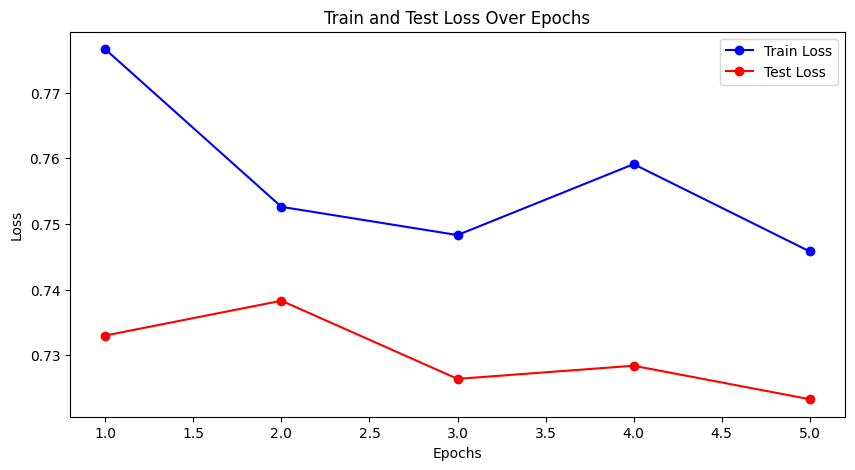

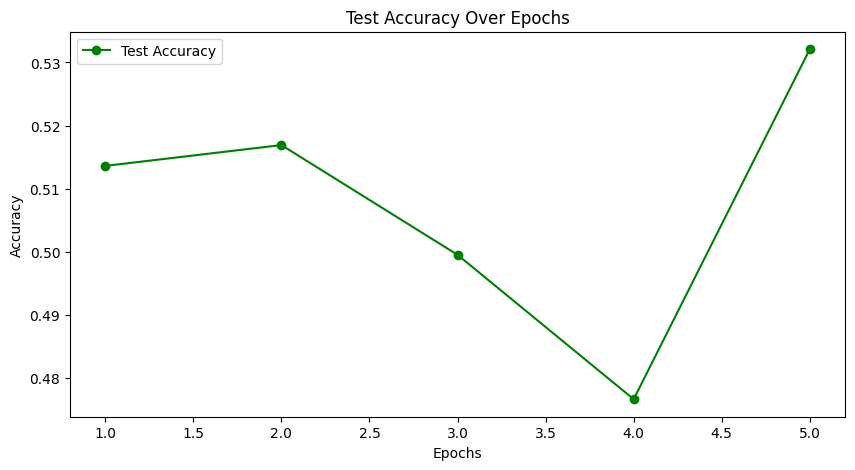

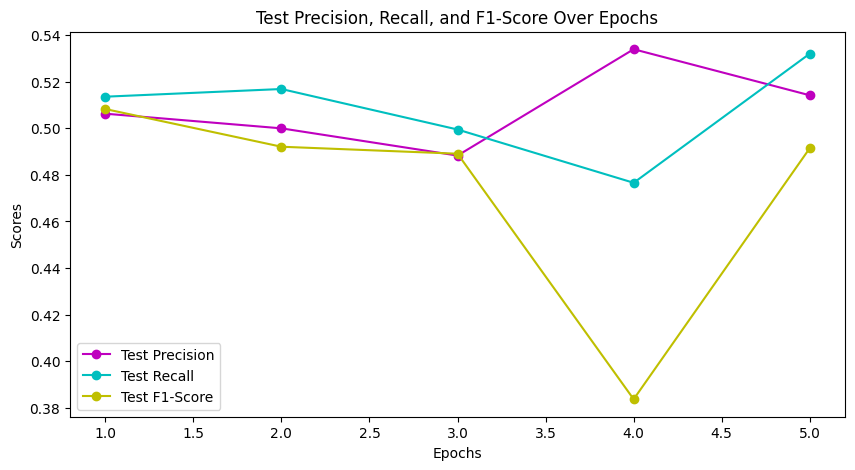

Sample 1:
Input IDs: [  101  2632  3597  2050  6022  2904  2049  2379  2744 13395 17680  1012
  3746  3120  1024  2131  3723  4871  2632  3597  2050  4297  1005  1055
  1006  6396  3366  1024  9779  1007  3570  2004  1996  4330  8545 12399
  1997  1996  3919  4753  3464  6151 27605 28357  1012  2004  2107  1010
  1996  2194  1005  1055  2117  4284 16565  8312  4838  1037  3677  1997
  6179  2592  2005  9387 26481  1996  2783 16565  2161  1012  2292  1005
  1055  2202  1037  3553  2298  2012  2054  2632  3597  2050  1005  1055
  2968  2056  1012  2632  3597  2050  1005  1055  2203  3006 17680  1996
  2190  2126  2000  2298  2012  5609  2003  2000 12826  1996  6745  2203
  3006  3930 17680  2007 17680  2015  2445  1999  3025  7728  1012  2445
  1996 26118  1999  1996  3452  3930 17680  1997  2087 22171  1999  2355
  1010  2632  3597  2050  1005  1055  3189  3084  3492  2204  3752  1012
  1996  7782  2098  4481  1999  1996  2795  2265  2073  2632  3597  2050
  2038  2081  3431  2000  2049

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Function to print some test sample results
def print_sample_results(model, test_loader, device, num_samples=5):
    model.eval()
    samples_printed = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            for i in range(len(labels)):
                if samples_printed >= num_samples:
                    return
                print(f"Sample {samples_printed + 1}:")
                print(f"Input IDs: {input_ids[i].cpu().numpy()}")
                print(f"True Label: {labels[i].item()}")
                print(f"Predicted Label: {preds[i].item()}\n")
                samples_printed += 1

# Assuming the following lists contain your previously stored metrics:
train_losses = [0.7766, 0.7526, 0.7483, 0.7591, 0.7458]
test_losses = [0.7330, 0.7383, 0.7264, 0.7284, 0.7233]
test_accuracies = [0.5136, 0.5169, 0.4995, 0.4766, 0.5321]
test_precision_scores = [0.5063, 0.5000, 0.4883, 0.5340, 0.5142]
test_recall_scores = [0.5136, 0.5169, 0.4995, 0.4766, 0.5321]
test_f1_scores = [0.5083, 0.4921, 0.4891, 0.3836, 0.4915]

# Generate a text summary
for epoch in range(len(train_losses)):
    print(f"Epoch {epoch + 1}/{len(train_losses)}")
    print(f"Train Loss: {train_losses[epoch]:.4f}")
    print(f"Test Loss: {test_losses[epoch]:.4f}")
    print(f"Test Accuracy: {test_accuracies[epoch]:.4f}")
    print(f"Test Precision: {test_precision_scores[epoch]:.4f}")
    print(f"Test Recall: {test_recall_scores[epoch]:.4f}")
    print(f"Test F1-Score: {test_f1_scores[epoch]:.4f}")
    print("\n")

# Plotting
epochs = range(1, len(train_losses) + 1)

# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, test_losses, 'ro-', label='Test Loss')
plt.title('Train and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_accuracies, 'go-', label='Test Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Precision, Recall, and F1-score plots
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_precision_scores, 'mo-', label='Test Precision')
plt.plot(epochs, test_recall_scores, 'co-', label='Test Recall')
plt.plot(epochs, test_f1_scores, 'yo-', label='Test F1-Score')
plt.title('Test Precision, Recall, and F1-Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.legend()
plt.show()

# Print sample results
print_sample_results(model, test_loader, device, num_samples=5)
